## Rebalancing Portfolios II

In [21]:
import pandas as pd
import numpy  as np

from tiingo import TiingoClient                       
tiingo = TiingoClient({'api_key':'f10f5d79cf2567b045cc7e9b595a6fec0f5321d2'})

import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice.

Get S&P500 [sector ETFs](https://www.sectorspdr.com/sectorspdr/) for technology, consumer staples and financials:

In [22]:
PRICE       = tiingo.get_dataframe(['XLK', 'XLP', 'XLF'],'2000-01-01', metric_name='adjClose')
PRICE.index = pd.to_datetime(PRICE.index).tz_convert(None)

RET = PRICE.pct_change()
RET[-3:]

,XLK,XLP,XLF
2021-03-22,0.019623,0.010499,-0.012822
2021-03-23,-0.006218,0.004197,-0.013976
2021-03-24,-0.012133,-0.003881,0.003619


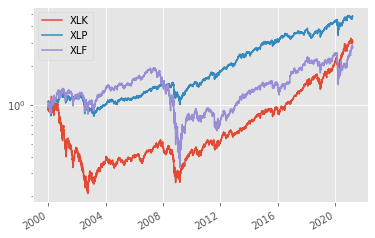

In [23]:
RET.add(1).cumprod().plot(logy=True)

### Rebalance Loop

Equal-weight portfolio:

In [24]:
weights = pd.Series({'XLK':1/3, 'XLP':1/3, 'XLF':1/3})

Suppose we rebalance at the end of each month:

In [25]:
def get_rebalance_dates(frequency):
    group = getattr(PRICE.index, frequency) 
    return PRICE[:1].index.union(PRICE.groupby([PRICE.index.year, group]).tail(1).index)


rebalance_dates = get_rebalance_dates('month') 
rebalance_dates

DatetimeIndex(['2000-01-03', '2000-01-31', '2000-02-29', '2000-03-31',
               '2000-04-28', '2000-05-31', '2000-06-30', '2000-07-31',
               '2000-08-31', '2000-09-29',
               ...
               '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30',
               '2020-10-30', '2020-11-30', '2020-12-31', '2021-01-29',
               '2021-02-26', '2021-03-24'],
              dtype='datetime64[ns]', length=256, freq=None)

We use a series to store the daily portfolio values.     
Our portfolio value equals $1 on the first trading date:

In [26]:
portfolio_value = pd.Series(1, index= [rebalance_dates [0]])
portfolio_value

2000-01-03    1
dtype: int64

First holding period:

In [27]:
start_date = rebalance_dates [0]
end_date   = rebalance_dates [1]

print('start:', start_date, 'end:', end_date)

start: 2000-01-03 00:00:00 end: 2000-01-31 00:00:00


Compound return of the assets during this holding period:

In [28]:
cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
cum_ret

,XLK,XLP,XLF
2000-01-04,0.949315,0.971868,0.956294
2000-01-05,0.949856,0.986374,0.956731
2000-01-06,0.904221,1.007473,0.990385
2000-01-07,0.919913,1.071648,1.006556
2000-01-10,0.954906,1.047473,0.989073
2000-01-11,0.927850,1.047473,0.972465
2000-01-12,0.923882,1.052747,0.991696
2000-01-13,0.932359,1.058462,1.021853
2000-01-14,0.953824,1.061978,1.045455
2000-01-18,0.958874,1.043956,1.010927


At the start of each period, our current portfolio value equals the most recent value of the last period:

In [29]:
portfolio_value.iloc[-1]

1

Dollar amounts we invest in the assets at the start of the current holding period:

In [30]:
new_positions = portfolio_value.iloc[-1] * weights 
new_positions

XLK    0.333333
XLP    0.333333
XLF    0.333333
dtype: float64

Dollar amounts we have in these assets during the current holding period:

In [31]:
start_to_end_positions = new_positions * cum_ret
start_to_end_positions

,XLK,XLP,XLF
2000-01-04,0.316438,0.323956,0.318765
2000-01-05,0.316619,0.328791,0.318910
2000-01-06,0.301407,0.335824,0.330128
2000-01-07,0.306638,0.357216,0.335519
2000-01-10,0.318302,0.349158,0.329691
2000-01-11,0.309283,0.349158,0.324155
2000-01-12,0.307961,0.350916,0.330565
2000-01-13,0.310786,0.352821,0.340618
2000-01-14,0.317941,0.353993,0.348485
2000-01-18,0.319625,0.347985,0.336976


Total portfolio value during the current holding period:

In [32]:
start_to_end_positions.sum('columns')

2000-01-04    0.959159
2000-01-05    0.964320
2000-01-06    0.967359
2000-01-07    0.999373
2000-01-10    0.997151
2000-01-11    0.982596
2000-01-12    0.989442
2000-01-13    1.004225
2000-01-14    1.020419
2000-01-18    1.004586
2000-01-19    1.006452
2000-01-20    0.997362
2000-01-21    0.989748
2000-01-24    0.963582
2000-01-25    0.969444
2000-01-26    0.974065
2000-01-27    0.980855
2000-01-28    0.955388
2000-01-31    0.980314
dtype: float64

Now append these values to the previous portfolio value:

In [33]:
portfolio_value = portfolio_value.append(start_to_end_positions.sum('columns'))
portfolio_value

2000-01-03    1.000000
2000-01-04    0.959159
2000-01-05    0.964320
2000-01-06    0.967359
2000-01-07    0.999373
2000-01-10    0.997151
2000-01-11    0.982596
2000-01-12    0.989442
2000-01-13    1.004225
2000-01-14    1.020419
2000-01-18    1.004586
2000-01-19    1.006452
2000-01-20    0.997362
2000-01-21    0.989748
2000-01-24    0.963582
2000-01-25    0.969444
2000-01-26    0.974065
2000-01-27    0.980855
2000-01-28    0.955388
2000-01-31    0.980314
dtype: float64

And now repeat this procedure for the next holding period:

In [35]:
start_date = rebalance_dates[1]
end_date   = rebalance_dates[2]

print('start:', start_date, 'end:', end_date)

start: 2000-01-31 00:00:00 end: 2000-02-29 00:00:00


In [37]:
cum_ret = RET[start_date:end_date][1:].add(1).cumprod()

In [38]:
portfolio_value.iloc[-1]

0.9803143153152252

In [39]:
start_to_end_positions[-1:]

,XLK,XLP,XLF
2000-01-31,0.303992,0.340366,0.335956


In [40]:
new_positions = portfolio_value.iloc[-1] * weights  # dollars invested at start of this period
new_positions

XLK    0.326771
XLP    0.326771
XLF    0.326771
dtype: float64

In [41]:
start_to_end_positions = new_positions  * cum_ret
start_to_end_positions

,XLK,XLP,XLF
2000-02-01,0.333687,0.323536,0.328614
2000-02-02,0.336078,0.324239,0.325213
2000-02-03,0.345773,0.319738,0.323229
2000-02-04,0.349780,0.321285,0.319970
2000-02-07,0.353852,0.319175,0.316569
2000-02-08,0.357083,0.323114,0.320111
2000-02-09,0.352624,0.320301,0.312601
2000-02-10,0.361026,0.309469,0.303957
2000-02-11,0.351460,0.303561,0.304665
2000-02-14,0.351654,0.305109,0.307358


Sum the positions and append them to the portfolio value:

In [42]:
portfolio_value = portfolio_value.append(start_to_end_positions.sum('columns'))  
portfolio_value

2000-01-03    1.000000
2000-01-04    0.959159
2000-01-05    0.964320
2000-01-06    0.967359
2000-01-07    0.999373
2000-01-10    0.997151
2000-01-11    0.982596
2000-01-12    0.989442
2000-01-13    1.004225
2000-01-14    1.020419
2000-01-18    1.004586
2000-01-19    1.006452
2000-01-20    0.997362
2000-01-21    0.989748
2000-01-24    0.963582
2000-01-25    0.969444
2000-01-26    0.974065
2000-01-27    0.980855
2000-01-28    0.955388
2000-01-31    0.980314
2000-02-01    0.985837
2000-02-02    0.985530
2000-02-03    0.988740
2000-02-04    0.991035
2000-02-07    0.989596
2000-02-08    1.000308
2000-02-09    0.985525
2000-02-10    0.974452
2000-02-11    0.959687
2000-02-14    0.964121
2000-02-15    0.972267
2000-02-16    0.959720
2000-02-17    0.959137
2000-02-18    0.932907
2000-02-22    0.939682
2000-02-23    0.942472
2000-02-24    0.934726
2000-02-25    0.922143
2000-02-28    0.932498
2000-02-29    0.941576
dtype: float64

And now loop over all rebalance dates:

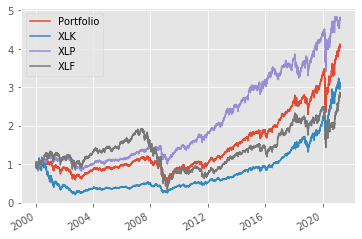

In [49]:
def run_backtest(frequency):
    rebalance_dates = get_rebalance_dates(frequency)    
    weights         = pd.Series({'XLK':1/3, 'XLP':1/3, 'XLF':1/3})
    portfolio_value = pd.Series(1,index=[rebalance_dates[0]])

    for i in range(len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]
        
        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        new_positions = portfolio_value.iloc[-1] * weights
        
        start_to_end_positions = new_positions  * cum_ret
        
        portfolio_value = portfolio_value.append(start_to_end_positions.sum('columns'))  
        
    return portfolio_value

value = run_backtest('quarter')

value.to_frame('Portfolio').join(RET.add(1).cumprod()).plot()  #turn series to DataFrame, the name given becomes the column label...then join table

In [50]:
pd.DataFrame(columns=weights.index, index=[rebalance_dates[0]])

,XLK,XLP,XLF
2000-01-03,NaN,NaN,NaN


### Portfolio turnover

In [55]:
def run_backtest(frequency):   
    rebalance_dates = get_rebalance_dates(frequency)
    weights         = pd.Series({'XLK':1/3, 'XLP':1/3, 'XLF':1/3})
    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    trades          = pd.DataFrame(columns=weights.index, index=[rebalance_dates[0]])
    previous_positions = weights

    for i in range(len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]
        
        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        new_positions = portfolio_value.iloc[-1] * weights
        
        start_to_end_positions = new_positions  * cum_ret
        
        portfolio_value = portfolio_value.append(start_to_end_positions.sum('columns'))  


            
        trades.loc[start_date]  = new_positions - previous_positions
        previous_positions      = start_to_end_positions.iloc[-1]

    return portfolio_value, trades

value, trades = run_backtest('month')
value

2000-01-03    1.000000
2000-01-04    0.959159
2000-01-05    0.964320
2000-01-06    0.967359
2000-01-07    0.999373
                ...   
2021-03-18    4.004622
2021-03-19    3.989523
2021-03-22    4.011263
2021-03-23    3.990086
2021-03-24    3.973880
Length: 5340, dtype: float64

Daily trades:

In [56]:
trades

,XLK,XLP,XLF
2000-01-03,0,0,0
2000-01-31,0.0227791,-0.0135949,-0.00918427
2000-02-29,-0.0472963,0.0252081,0.0220882
2000-03-31,0.00554506,0.0200727,-0.0256178
2000-04-28,0.0283323,-0.021651,-0.00668135
...,...,...,...
2020-10-30,0.0233821,-0.000506447,-0.0228757
2020-11-30,0.00561389,0.0481667,-0.0537806
2020-12-31,-0.0126606,0.0345331,-0.0218725
2021-01-29,-0.0216179,0.0310407,-0.00942282


Turnover example:

In [57]:
# Before rebalancing:
position_A = 80
position_B = 40
position_C = 30

# After rebalancing:
position_A = 50
position_B = 50
position_C = 50

Total dollar amount traded:

In [58]:
total_trade = abs(-30) + 10 + 20
total_trade 

60

Turnover:

In [59]:
total_trade/2

30.0

Daily portfolio turnover (total dollar amount realloacted):      

In [66]:
turnover = trades.abs().sum('columns').div(2)
turnover

2000-01-03    0.000000
2000-01-31    0.022779
2000-02-29    0.047296
2000-03-31    0.025618
2000-04-28    0.028332
                ...   
2020-10-30    0.023382
2020-11-30    0.053781
2020-12-31    0.034533
2021-01-29    0.031041
2021-02-26    0.095298
Length: 255, dtype: float64

Cumulative trades:

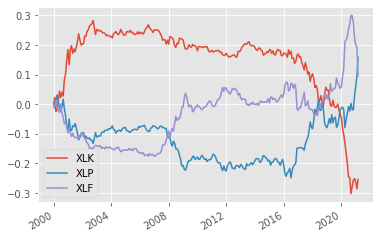

In [70]:
trades.cumsum().plot()

Plot the turnover:

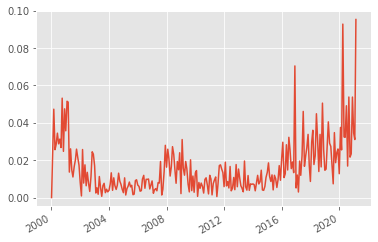

In [71]:
turnover.plot()

Total turnover per year:

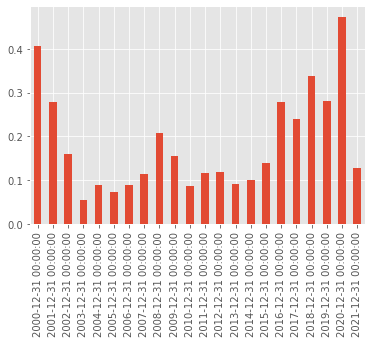

In [77]:
turnover.resample('A').sum().plot.bar()

Turnover ratio:

In [81]:
value.resample('A').mean() # average value of portfolio throughout the year

2000-12-31    1.035880
2001-12-31    0.913510
2002-12-31    0.757511
2003-12-31    0.742409
2004-12-31    0.871715
2005-12-31    0.912546
2006-12-31    1.005653
2007-12-31    1.136991
2008-12-31    0.927793
2009-12-31    0.743322
2010-12-31    0.914488
2011-12-31    0.996438
2012-12-31    1.122922
2013-12-31    1.359668
2014-12-31    1.610194
2015-12-31    1.791237
2016-12-31    1.904853
2017-12-31    2.333505
2018-12-31    2.615181
2019-12-31    2.864844
2020-12-31    3.232009
2021-12-31    3.901797
Freq: A-DEC, dtype: float64

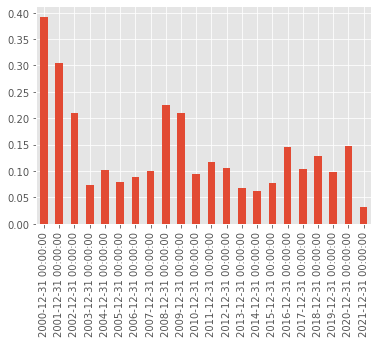

In [82]:
turnover.resample('A').sum().div( value.resample('A').mean()).plot.bar()